In [351]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import plotly
import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.express as px
import chart_studio
import chart_studio.plotly as py
import calmap
import datetime
import tensorflow as tf
import os
import random
import re
import plotly.offline as pyoff
import plotly.graph_objs as go
import swifter

from datetime import date
from plotly.subplots import make_subplots
from itertools import cycle, product
from statsmodels.tsa.seasonal import STL
from scipy.stats import boxcox
from pmdarima.arima import auto_arima
from pmdarima.utils import diff_inv
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.initializers import *
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from scipy.special import boxcox1p, inv_boxcox1p
import matplotlib.patches as mpatches
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import GridSearchCV
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from IPython.display import HTML, display
from swifter import set_defaults

In [2]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Herikc Brecher" --iversions

Author: Herikc Brecher

matplotlib  : 3.5.1
plotly      : 5.6.0
swifter     : 1.3.4
keras       : 2.10.0
calmap      : 0.0.9
chart_studio: 1.1.0
tensorflow  : 2.10.0
seaborn     : 0.11.2
numpy       : 1.21.5
pandas      : 1.4.2
re          : 2.2.1



In [3]:
# Variaveis globais
SEED = 84796315
FEATURES = 7
EPOCHS = 100
BATCH_SIZE = 1000
EXECUTE_GRID_SEARCH = False

In [4]:
# Configurando seeds
os.environ['PYTHONHASHSEED'] = str(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [5]:
# Exibindo toda tela
display(HTML('<style>.container { width:100% !important; }</style>'))
pd.options.plotting.backend = 'matplotlib'

In [6]:
# Configurando swifter 
set_defaults(
    npartitions = None,
    dask_threshold = 1,
    scheduler = "processes",
    progress_bar = True,
    progress_bar_desc = None,
    allow_dask_on_strings = True,
    force_parallel = True,
)

# 1. Preparando Conjunto de Pedidos

In [7]:
# Import dataset
dtOrders = pd.read_csv('../data/olist_orders_dataset.csv', encoding = 'utf8')

In [8]:
# Colunas do tipo data
dateColumns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',\
               'order_delivered_customer_date', 'order_estimated_delivery_date']

# Dataset de analise temporal
dtOrdersAdjusted = dtOrders.copy()

In [9]:
# Convertendo columas de data para date
for col in dateColumns:
    dtOrdersAdjusted[col] = pd.to_datetime(dtOrdersAdjusted[col], format = '%Y-%m-%d %H:%M:%S')

In [10]:
# Dropando valores NA
dtOrdersAdjusted = dtOrdersAdjusted.dropna()

In [11]:
dtOrdersAdjusted.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

# 2. Iniciando Analise Seasonal

In [12]:
dtHistory = pd.to_datetime(dtOrdersAdjusted['order_purchase_timestamp']).dt.date

start = dtHistory.min()
end = dtHistory.max()

idx = pd.date_range(start, end, normalize = True)

seriesOriginal = dtHistory.value_counts(sort = False).sort_index().reindex(idx, fill_value = 0)

dtHistory = pd.DataFrame(seriesOriginal).reset_index()

Principais outliers identificados:

- 1 de setembro de 2016 a 31 de dezembro de 2016: Dados quase inexistentes
- 24 de novembro de 2017: Pico de venda devido ao evento da blackfriday
- 17 de agosto de 2017 a 17 de outubro de 2017: Queda repentina nos dados

In [13]:
dtHistory

index  order_purchase_timestamp
0   2016-09-15                         1
1   2016-09-16                         0
2   2016-09-17                         0
3   2016-09-18                         0
4   2016-09-19                         0
..         ...                       ...
709 2018-08-25                        69
710 2018-08-26                        73
711 2018-08-27                        66
712 2018-08-28                        39
713 2018-08-29                        11

[714 rows x 2 columns]

In [14]:
# Plot

# Definição dos dados no plot (Iniciando em Fevereiro de 2017 para não destorcer os dados)
plot_data = [go.Scatter(x = dtHistory['index'],
                        y = dtHistory['order_purchase_timestamp'])]

# Layout
plot_layout = go.Layout(xaxis = {'title': 'Periodo'},
                        yaxis = {'title': 'Vendas'},
                        title = 'Vendas por dia')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)

pyoff.iplot(fig) 

In [15]:
# Remove outliers
seriesOriginal = seriesOriginal[datetime.date(2017, 1, 1): datetime.date(2018, 8, 17)]
pred_range = pd.date_range(datetime.date(2018, 8, 17), datetime.date(2018, 10, 17))
dtHistory = pd.DataFrame(seriesOriginal).reset_index()

In [16]:
# Plot

# Definição dos dados no plot (Iniciando em Fevereiro de 2017 para não destorcer os dados)
plot_data = [go.Scatter(x = dtHistory['index'],
                        y = dtHistory['order_purchase_timestamp'])]

# Layout
plot_layout = go.Layout(xaxis = {'title': 'Periodo'},
                        yaxis = {'title': 'Vendas'},
                        title = 'Vendas por dia')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)

pyoff.iplot(fig) 

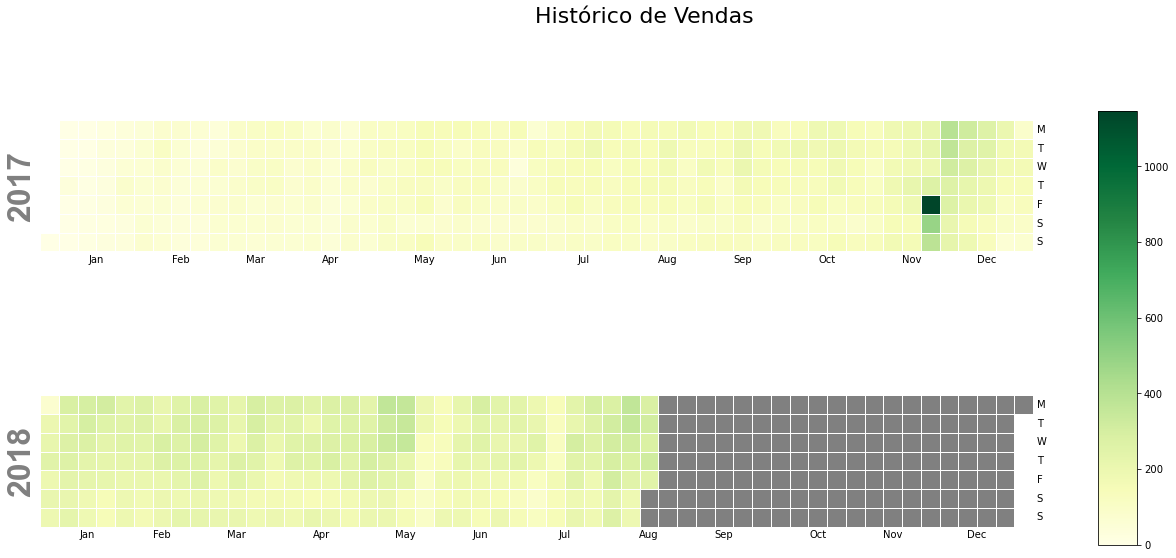

In [17]:
#Plot histórico de vendas por dia, mês e ano
fig, caxs = calmap.calendarplot(seriesOriginal, daylabels = 'MTWTFSS', fillcolor = 'grey',cmap = 'YlGn', fig_kws = dict(figsize = (18, 9)))
fig.suptitle('Histórico de Vendas', fontsize = 22)

fig.subplots_adjust(right = 0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.67])
fig.colorbar(caxs[0].get_children()[1], cax = cbar_ax)

plt.show()

In [18]:
# Criar grafico na estrutura STL 4 layers
def add_stl_plot(fig, res, legend):
    axs = fig.get_axes()
    
    # Nome de cada um dos subplots
    comps = ['trend', 'seasonal', 'resid']
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == 'resid':
            ax.plot(series, marker = 'o', linestyle = 'none')
        else:
            ax.plot(series)
            ax.legend(legend, frameon = False)

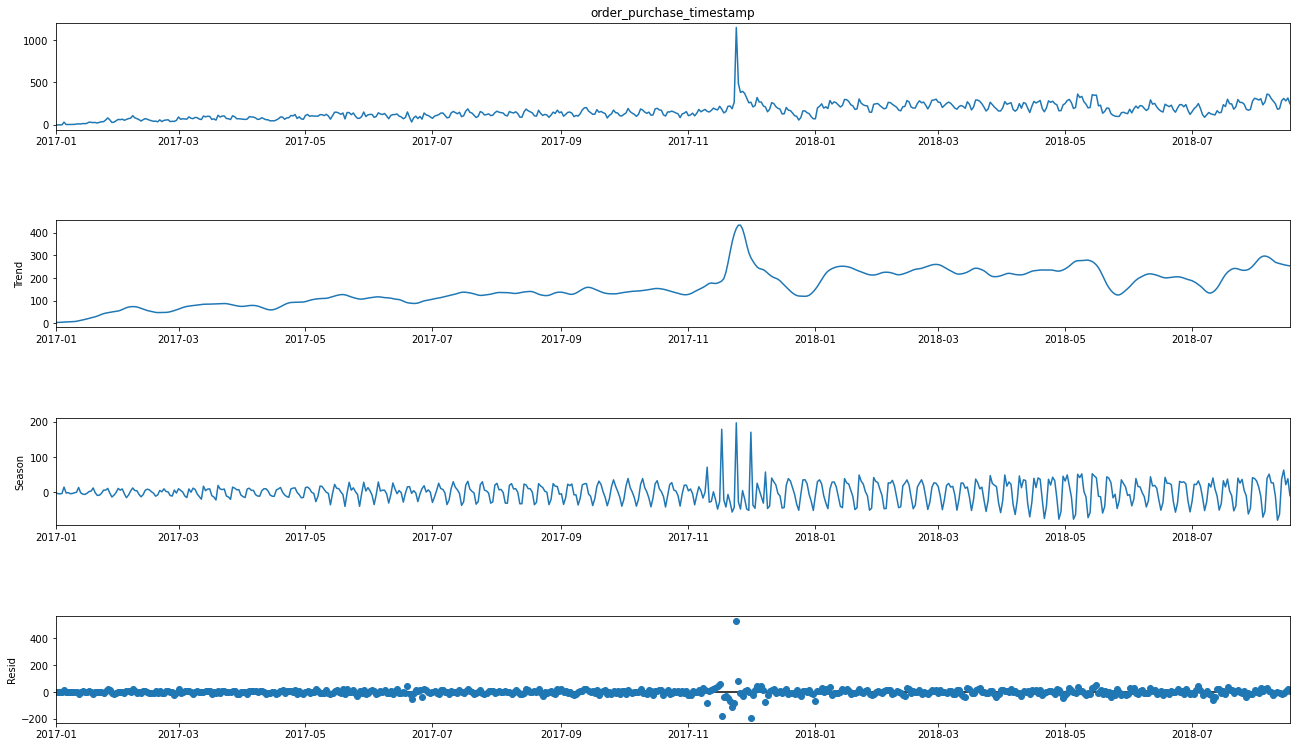

In [19]:
# Gerar STL
stl = STL(seriesOriginal)
stl_res = stl.fit()
fig = stl_res.plot()
fig.set_size_inches((20, 12))
plt.show()

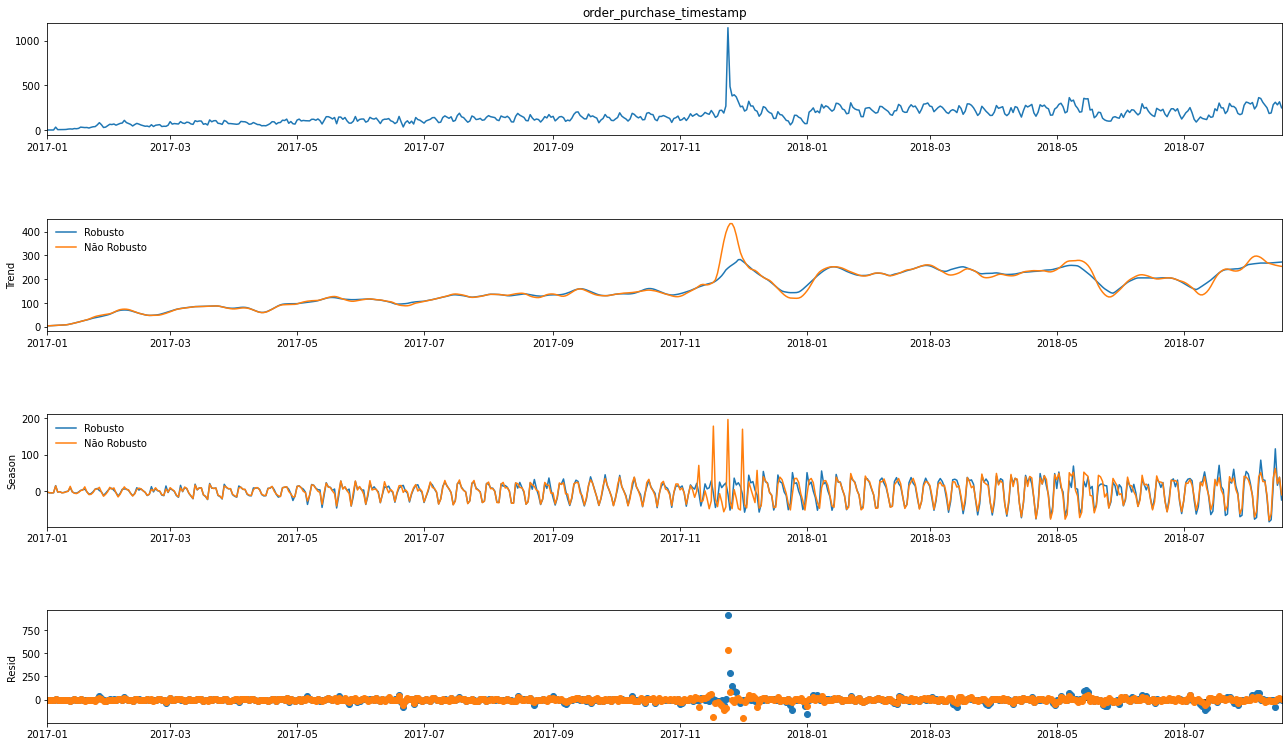

In [20]:
# Gerar STL não robusto e concatenar ao robusto
stl = STL(seriesOriginal, robust = True)
res_robust = stl.fit()
fig = res_robust.plot()
fig.set_size_inches((20, 12))
res_non_robust = STL(seriesOriginal, robust = False).fit()
add_stl_plot(fig, res_non_robust, ['Robusto', 'Não Robusto'])

In [21]:
# Gerando STL para separar cada um dos componentes
stl = STL(seriesOriginal)
res = stl.fit()

# Separando seriesDeseasonal
seriesDeseasonal = res.observed - res.seasonal

# Separando boxcox
seriesBoxCox, lmbda = boxcox(seriesOriginal+1)
seriesBoxCox = pd.Series(seriesBoxCox, index = seriesOriginal.index)

# Separando stationary
seriesResidual = seriesOriginal.diff(7).dropna()
xi = seriesOriginal.iloc[:7]

## 2.1 Teste Estacionário ADF

Os testes abaixo concluiram:

O teste aceita a hipótese nula em que a série não é estácionária para os dados originais e deseasonal. Já para os dados residuais esses aceitaram a hipótese alternativa que os dados são estacionários. 

ADF teste:

- Hipótese Nula(HO): A série possui unit root ou não é estacionária.
- Hipótese Alternativa(HA):  A série não possui unit root ou é estacionária.

In [22]:
print("Os dados são estacionários?\n")
testResult = adfuller(seriesOriginal, autolag = 'AIC')
print("Valor Teste = {:.3f}".format(testResult[0]))
print("Valor de P: = {:.3f}".format(testResult[1]))
print("\nValores Críticos:")

for p, v in testResult[4].items():
    print("\t{}: {} - O dataset {} é estacionário com {}% de confiança".format(p, v, "não" if v < testResult[0] else "", 100 - int(p[:-1])))

Os dados são estacionários?

Valor Teste = -2.616
Valor de P: = 0.090

Valores Críticos:
	1%: -3.441694608475642 - O dataset não é estacionário com 99% de confiança
	5%: -2.866544718556839 - O dataset não é estacionário com 95% de confiança
	10%: -2.5694353738653684 - O dataset  é estacionário com 90% de confiança


In [23]:
print("Os dados deseasonal são estacionários?")
testResult = adfuller(seriesDeseasonal, autolag = 'AIC')
print("Valor Teste = {:.3f}".format(testResult[0]))
print("Valor de P: = {:.3f}".format(testResult[1]))
print("\nValores Críticos:")

for p, v in testResult[4].items():
    print("\t{}: {} - O dataset {} é estacionário com {}% de confiança".format(p, v, "não" if v < testResult[0] else "", 100 - int(p[:-1])))

Os dados deseasonal são estacionários?
Valor Teste = -2.536
Valor de P: = 0.107

Valores Críticos:
	1%: -3.441694608475642 - O dataset não é estacionário com 99% de confiança
	5%: -2.866544718556839 - O dataset não é estacionário com 95% de confiança
	10%: -2.5694353738653684 - O dataset não é estacionário com 90% de confiança


In [24]:
print("Os dados residuais são estacionários?")
testResult = adfuller(seriesResidual, autolag = 'AIC')
print("Valor Teste = {:.3f}".format(testResult[0]))
print("Valor de P: = {:.3f}".format(testResult[1]))
print("\nValores Críticos:")

for p, v in testResult[4].items():
    print("\t{}: {} - O dataset {} é estacionário com {}% de confiança".format(p, v, "não" if v < testResult[0] else "", 100 - int(p[:-1])))

Os dados residuais são estacionários?
Valor Teste = -6.802
Valor de P: = 0.000

Valores Críticos:
	1%: -3.441834071558759 - O dataset  é estacionário com 99% de confiança
	5%: -2.8666061267054626 - O dataset  é estacionário com 95% de confiança
	10%: -2.569468095872659 - O dataset  é estacionário com 90% de confiança


# 3. Modelagem

Toda a etapa de modelagem será considerada com 5 passos a frente de previsão.

In [25]:
# Controle de resultados de toda fase de modelagem
result = pd.DataFrame(columns = ['Algorithm', 'MSE', 'RMSE', 'MAE', 'Mean_Real_Value', 'Mean_Predict_Value'])

In [26]:
split_range = TimeSeriesSplit(n_splits = 8, max_train_size = pred_range.shape[0], test_size = pred_range.shape[0])

In [27]:
# Adiciona o registro ao dataset
def record(result, algorithm, mse = -1, rmse = -1, mae = -1, mrv = -1, mpv = -1, show = True):
    new = pd.DataFrame(dict(Algorithm = algorithm, MSE = mse, RMSE = rmse, MAE = mae, Mean_Real_Value = mrv,\
                            Mean_Predict_Value = mpv), index = [0])
    result = pd.concat([result, new], ignore_index = True)
    
    if show:
        display(result)
    
    return result

In [28]:
# Plot no formato de 4 layers, seguindo o STL para cada um dos modelos
def plot(index, pred, mse, title, fig = None, ax = None, ylabel = ''):
    global seriesOriginal
    
    empty_fig = fig is None
    
    if empty_fig:
        fig, ax = plt.subplots(figsize = (13, 6))
    else: 
        ax.set_ylabel(ylabel)
                
    ax.set_title(title)    
    patch_ = mpatches.Patch(color = 'white', label = f'MSE: {np.mean(mse):.1e}')
    L1 = ax.legend(handles = [patch_], loc = 'upper left', fancybox = True, framealpha = 0.7,  handlelength = 0)
    ax.add_artist(L1)
    
    sns.lineplot(x = seriesOriginal.index, y = seriesOriginal, label = 'Real', ax = ax)
    sns.lineplot(x = index, y = pred, label = 'Previsto', ax = ax)
    ax.axvline(x = index[0], color = 'red')
    ax.legend(loc = 'upper right')
    
    if empty_fig:
        plt.show()
    else:
        return fig

In [29]:
# Calculo para previsão e teste quando utilizado a série Original
def calcPredTestOriginal(train, pred, test):
    return pred, test, 0

In [30]:
# Calculo para previsão e teste quando utilizado a série seriesDeseasonal
def calcPredTestseriesDeseasonal(train, pred, test):
    # Removendo a sazonalidade da série e convertendo para o shape correto
    last_seasonal = res.seasonal.reindex_like(train).tail(stl.period)
    pred = pred + np.fromiter(cycle(last_seasonal), count = pred.shape[0], dtype = float)
    test = test + res.seasonal.reindex_like(test)
    
    return pred, test, 1

In [31]:
# Calculo para previsão e teste quando utilizado a série BoxCox
def calcPredTestBoxCox(train, pred, test):
    # Reverdendo a normalização do boxcox
    pred = inv_boxcox1p(pred, lmbda)
    test = inv_boxcox1p(test, lmbda)
    
    return pred, test, 2

In [32]:
# Calculo para previsão e teste quando utilizado a série Stationary
def calcPredTestStationary(train, pred, test):
    # Calculando a diferença da sazonalidade
    xi = seriesOriginal.reindex_like(train).tail(FEATURES)
    
    totalLen = len(pred) + len(xi) 
    ix = pd.date_range(xi.index[0], periods = totalLen)  
    inv = diff_inv(pred, FEATURES, xi = xi) + np.fromiter(cycle(xi), count = totalLen, dtype = float)  
    inv = pd.Series(inv, index = ix, name = 'order_purchase_timestamp')
    pred = inv.iloc[FEATURES:]
    
    totalLen = len(test) + len(xi) 
    ix = pd.date_range(xi.index[0], periods = totalLen)  
    inv = diff_inv(test, FEATURES, xi = xi) + np.fromiter(cycle(xi), count = totalLen, dtype = float)  
    inv = pd.Series(inv, index = ix, name = 'order_purchase_timestamp')
    test = inv.iloc[FEATURES:]
    
    return pred, test, 3

## 3.1 TSR (Time Series Regression)

In [33]:
# Report para Time Series Regressor, realiza o treino do modelo, adiciona aos resultados e faz o plot de acompanhamento
def reportTSR(data, modelName, calcFunction):
    global result
    global figs
    
    mse = []
    rmse = []
    mae = []
    mrv = []
    mpv = []
    
    title = modelName + ' - Time Series Regression'
    
    for train_id, test_id in split_range.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]
    
        gen = TimeseriesGenerator(train, train, FEATURES, batch_size = BATCH_SIZE)

        X_train = gen[0][0]
        y_train = gen[0][1]

        lr = LinearRegression()
        lr.fit(X_train, y_train)
        X_pred = y_train[-FEATURES:].reshape(1,-1)
        pred = np.empty(test.shape[0])

        for i in range(len(pred)):
            forecast = lr.predict(X_pred)
            X_pred = np.delete(X_pred, 0, 1)
            X_pred = np.concatenate((X_pred, forecast.reshape(-1, 1)), 1)    
            pred[i] = forecast
        
        pred, test, indexPlot = calcFunction(train, pred, test)

        mse.append(mean_squared_error(pred, test, squared = True))
        rmse.append(mean_squared_error(pred, test, squared = False))
        mae.append(mean_absolute_error(pred, test))
        mrv.append(np.mean(test))
        mpv.append(np.mean(pred))
    
    result = record(result, title, np.mean(mse), np.mean(rmse), np.mean(mae), np.mean(mrv), np.mean(mpv), False)
    return plot(test.index, pred, mse, title, figs, axs[indexPlot], modelName)

In [34]:
# Reset da figura
figs, axs = plt.subplots(nrows = 4, sharex = True, figsize = (13,6))
figs.tight_layout()
plt.close()

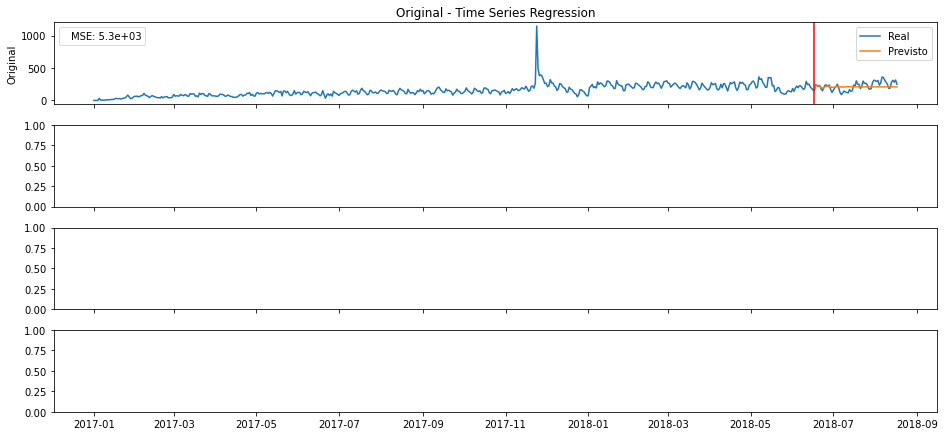

In [35]:
reportTSR(seriesOriginal.copy(), 'Original', calcPredTestOriginal)

## 3.2 Deseasonal - TSR (Time Series Regression)

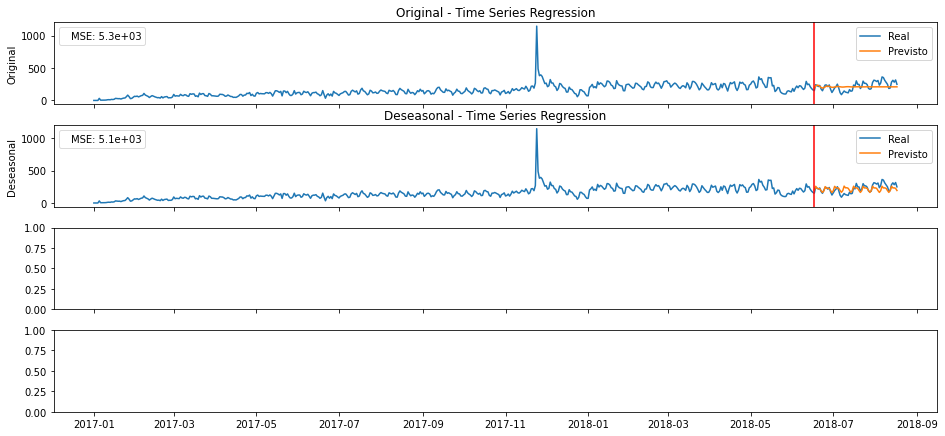

In [36]:
reportTSR(seriesDeseasonal.copy(), 'Deseasonal', calcPredTestseriesDeseasonal)

## 3.3 BoxCox - TSR (Time Series Regression)

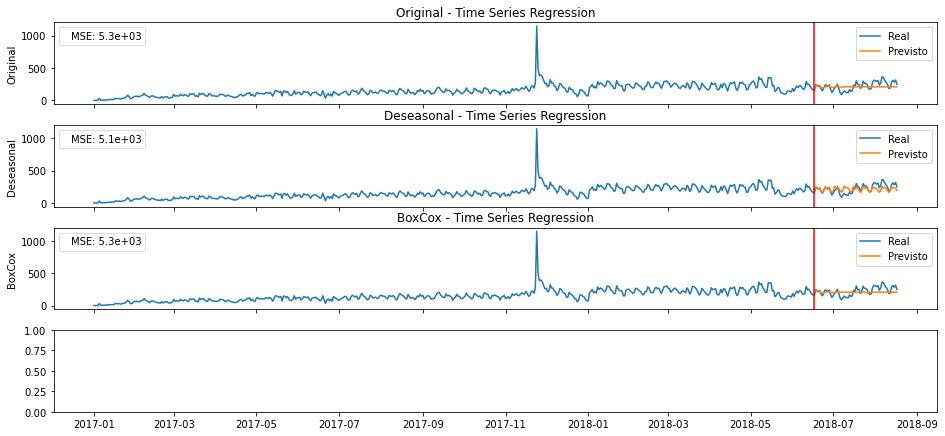

In [37]:
reportTSR(seriesBoxCox.copy(), 'BoxCox', calcPredTestBoxCox)

## 3.4 Residual - TSR (Time Series Regression)

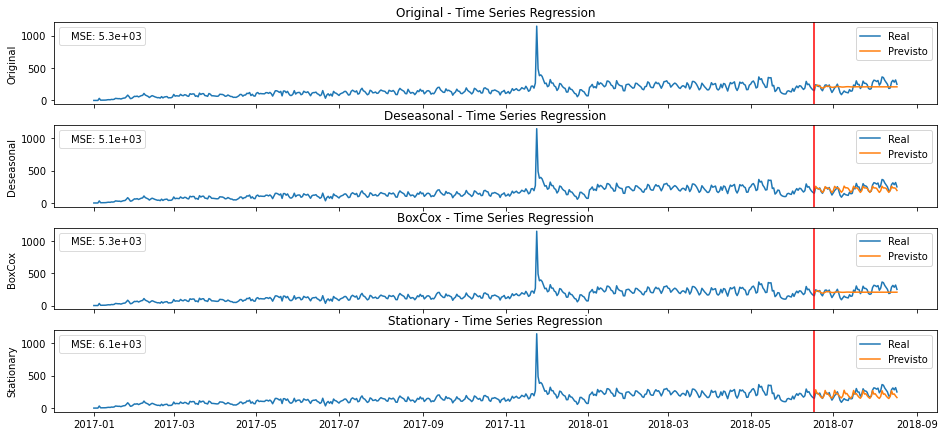

In [38]:
reportTSR(seriesResidual.copy(), 'Stationary', calcPredTestStationary)

In [39]:
result

Algorithm          MSE       RMSE        MAE  \
0    Original - Time Series Regression  5296.329792  60.784585  42.960631   
1  Deseasonal - Time Series Regression   5081.77776  58.208746  40.122247   
2      BoxCox - Time Series Regression  5328.602465  61.060147  43.254815   
3  Stationary - Time Series Regression  6057.828087  64.323443  46.538896   

  Mean_Real_Value Mean_Predict_Value  
0      179.560484         168.008596  
1      179.560484         164.670085  
2      179.560484         165.399796  
3      179.560484         184.267746

## 3.5 Exponential Smoothing

In [40]:
# Função utilizada para o hypertuning de alpha, beta e gamma do Exponential Smoothing
def GSES(data, modelName, alpha, beta, gamma, damping_trend, calcFunction):    
    mse = []
    
    for train_id, test_id in split_range.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]
        
        try:
            with catch_warnings():
                filterwarnings('ignore')
                ES = (
                    ExponentialSmoothing(train, trend = 'add', seasonal = 'add', seasonal_periods = FEATURES, damped_trend = True)
                    .fit(smoothing_level = alpha, smoothing_trend = beta, smoothing_seasonal = gamma, method = 'ls', damping_trend = damping_trend)
                )

                pred = ES.forecast(test.shape[0])

                pred, test, _ = calcFunction(train, pred, test)

                mse.append(mean_squared_error(pred, test, squared = True))
        
        except:
            mse.append(-1)
    
    return np.mean(mse)

In [41]:
# Função utilizada para o hypertuning de demais parâmetros do Exponential Smoothing
def GSESOPT(data, modelName, trend, season, periods, bias, method, calcFunction):
    mse = []
    
    for train_id, test_id in split_range.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]
        
        try:
            with catch_warnings():
                filterwarnings('ignore')
                ES = (
                    ExponentialSmoothing(train, trend = trend, seasonal = season, seasonal_periods = periods)
                    .fit(remove_bias = bias, method = method, optimized = True)
                )

                pred = ES.forecast(test.shape[0])

                pred, test, _ = calcFunction(train, pred, test)

                mse.append(mean_squared_error(pred, test, squared = True))       
        except:
            mse.append(-1)
    
    return np.mean(mse)

In [42]:
# Report para Exponential Smoothing, realiza o treino do modelo, adiciona aos resultados e faz o plot de acompanhamento
def reportES(data, modelName, model_kwargs, fit_kwargs, calcFunction):
    global result
    global figs
    
    mse = []
    rmse = []
    mae = []
    mrv = []
    mpv = []
    
    title = modelName + ' - Exponential Smoothing'
    indexPlot = 0
    
    for train_id, test_id in split_range.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]
        
        ES = (
            ExponentialSmoothing(train, trend = model_kwargs['trend'], seasonal = model_kwargs['seasonal'], seasonal_periods = FEATURES, damped_trend = model_kwargs['damped_trend'])
            .fit(smoothing_level = fit_kwargs['smoothing_level'], smoothing_trend = fit_kwargs['smoothing_trend'],\
                 smoothing_seasonal = fit_kwargs['smoothing_seasonal'], method = fit_kwargs['method'], damping_trend = fit_kwargs['damping_trend'])
        )
        
        pred = ES.forecast(test.shape[0])
             
        pred, test, indexPlot = calcFunction(train, pred, test)

        mse.append(mean_squared_error(pred, test, squared = True))
        rmse.append(mean_squared_error(pred, test, squared = False))
        mae.append(mean_absolute_error(pred, test))
        mrv.append(np.mean(test))
        mpv.append(np.mean(pred))
    
    result = record(result, title, np.mean(mse), np.mean(rmse), np.mean(mae), np.mean(mrv), np.mean(mpv), False)
    return plot(test.index, pred, mse, title, figs, axs[indexPlot], modelName)

In [43]:
# Função para gerar tabela de hypertuning ampla
def exp_smoothing_configs(seasonal = [None]):
    models = list()
    # Lista de argumentos
    t_params = ['add', 'mul']
    s_params = ['add', 'mul']
    p_params = seasonal
    r_params = [True, False]
    method_params = ['L-BFGS-B' , 'TNC', 'SLSQP', 'Powell', 'trust-constr', 'bh', 'ls']
    
    # Gerando lista de argumentos
    for t in t_params:
        for s in s_params:
            for p in p_params:
                for r in r_params:
                    for m in method_params:
                        cfg = [t, s, p, r, m]
                        models.append(cfg)
    return models

In [44]:
# Gerando tabela de hypertunning
alphas = betas = gammas = damping_trend = np.arange(1, step = 0.1)
hyperparam = pd.DataFrame(product(alphas, betas, gammas, damping_trend), columns = ['alpha', 'beta', 'gamma', 'damping_trend'])
hyperparam.head()

alpha  beta  gamma  damping_trend
0    0.0   0.0    0.0            0.0
1    0.0   0.0    0.0            0.1
2    0.0   0.0    0.0            0.2
3    0.0   0.0    0.0            0.3
4    0.0   0.0    0.0            0.4

In [45]:
%%time

# Treinamento do modelo 
if EXECUTE_GRID_SEARCH:  
    hyperparam['mse'] = hyperparam.swifter.apply(lambda x: GSES(seriesOriginal.copy(), 'Original',\
                                                x.alpha, x.beta, x.gamma, x.damping_trend, calcPredTestOriginal), axis = 1)

CPU times: total: 0 ns
Wall time: 0 ns


In [46]:
# Verificando o menor mse
if EXECUTE_GRID_SEARCH:
    display(hyperparam.query('mse == mse.min() and mse != -1'))

In [47]:
# Criando lista de argumentos ampla
params_ = exp_smoothing_configs([FEATURES])

In [48]:
hyperparam_ = pd.DataFrame(params_, columns = ['trend', 'season', 'periods', 'bias', 'method'])

In [49]:
len(hyperparam_)

56

In [50]:
hyperparam_.head()

trend season  periods  bias        method
0   add    add        7  True      L-BFGS-B
1   add    add        7  True           TNC
2   add    add        7  True         SLSQP
3   add    add        7  True        Powell
4   add    add        7  True  trust-constr

In [51]:
%%time

# Se True irá treinar com a nova lista mais ampla (pode demorar)
if EXECUTE_GRID_SEARCH:
    hyperparam_['mse'] = hyperparam_.swifter.apply(lambda x: GSESOPT(seriesOriginal.copy(), 'Original',\
                                                     x.trend, x.season, x.periods, x.bias, x.method, calcPredTestOriginal),\
                                   axis = 1)

CPU times: total: 0 ns
Wall time: 0 ns


In [52]:
if EXECUTE_GRID_SEARCH:
    display(hyperparam_.query('mse == mse.min() and mse != -1'))

In [53]:
# Reset da figura
figs, axs = plt.subplots(nrows = 4, sharex = True, figsize = (13, 6))
figs.align_ylabels()
figs.tight_layout()
plt.close()

In [54]:
model_kwargs = dict(trend = 'add', seasonal = 'add', seasonal_periods = FEATURES, damped_trend = True)
fit_kwargs = dict(smoothing_level = 0.1, smoothing_trend = 0.8, smoothing_seasonal = 0, method = 'ls', damping_trend = 0.8)

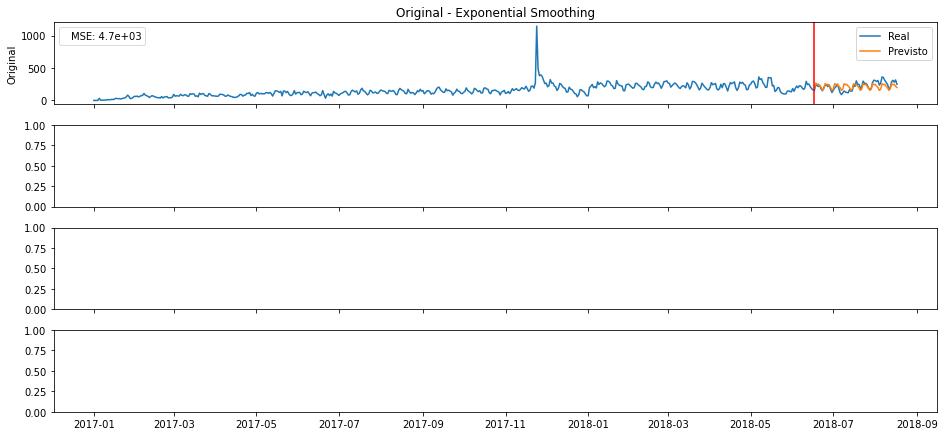

In [55]:
reportES(seriesOriginal.copy(), 'Original', model_kwargs, fit_kwargs, calcPredTestOriginal)

## 3.6 Deseasonal - Exponential Smoothing

#### O código abaixo é uma replicação do item 3.5, de forma que só foi alterado a base de entrada de seriesOriginal para seriesDeseasonal, assim verificando as diferenças de resultados ao utilizar diferentes transformações na base. Dessa forma,  não terá comentários nesse item.

In [56]:
alphas = betas = gammas = damping_trend = np.arange(1, step = 0.1)
hyperparam = pd.DataFrame(product(alphas, betas, gammas, damping_trend), columns = ['alpha', 'beta', 'gamma', 'damping_trend'])
hyperparam.head()

alpha  beta  gamma  damping_trend
0    0.0   0.0    0.0            0.0
1    0.0   0.0    0.0            0.1
2    0.0   0.0    0.0            0.2
3    0.0   0.0    0.0            0.3
4    0.0   0.0    0.0            0.4

In [57]:
%%time

if EXECUTE_GRID_SEARCH:
    hyperparam['mse'] = hyperparam.swifter.apply(lambda x: GSES(seriesDeseasonal.copy(), 'seriesDeseasonal',\
                                                x.alpha, x.beta, x.gamma, x.damping_trend, calcPredTestseriesDeseasonal), axis = 1)

CPU times: total: 0 ns
Wall time: 0 ns


In [58]:
if EXECUTE_GRID_SEARCH:
    display(hyperparam.query('mse == mse.min() and mse != -1'))

In [59]:
params_ = exp_smoothing_configs([FEATURES])

In [60]:
hyperparam_ = pd.DataFrame(params_, columns = ['trend', 'season', 'periods', 'bias', 'method'])

In [61]:
%%time
if EXECUTE_GRID_SEARCH:
    hyperparam_['mse'] = hyperparam_.swifter.apply(lambda x: GSESOPT(seriesDeseasonal.copy(), 'seriesDeseasonal',\
                                                     x.trend, x.season, x.periods, x.bias, x.method, calcPredTestseriesDeseasonal),\
                                   axis = 1)

CPU times: total: 0 ns
Wall time: 0 ns


In [62]:
if EXECUTE_GRID_SEARCH:
    display(hyperparam_.query('mse == mse.min() and mse != -1'))

In [63]:
model_kwargs = dict(trend = 'add', seasonal = 'add', seasonal_periods = FEATURES, damped_trend = True)
fit_kwargs = dict(smoothing_level = 0.1, smoothing_trend = 0.2, smoothing_seasonal = 0.5, method = 'ls', damping_trend = 0.8)

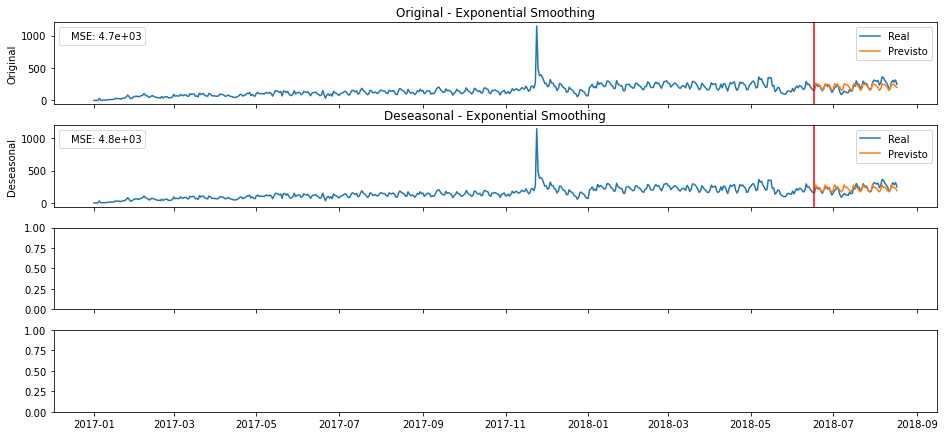

In [64]:
reportES(seriesDeseasonal.copy(), 'Deseasonal', model_kwargs, fit_kwargs, calcPredTestseriesDeseasonal)

## 3.7 BoxCox - Exponential Smoothing

#### O código abaixo é uma replicação do item 3.5, de forma que só foi alterado a base de entrada de seriesOriginal para boxcox, assim verificando as diferenças de resultados ao utilizar diferentes transformações na base. Dessa forma,  não terá comentários nesse item.

In [65]:
alphas = betas = gammas = damping_trend = np.arange(1, step = 0.1)
hyperparam = pd.DataFrame(product(alphas, betas, gammas, damping_trend), columns = ['alpha', 'beta', 'gamma', 'damping_trend'])
hyperparam.head()

alpha  beta  gamma  damping_trend
0    0.0   0.0    0.0            0.0
1    0.0   0.0    0.0            0.1
2    0.0   0.0    0.0            0.2
3    0.0   0.0    0.0            0.3
4    0.0   0.0    0.0            0.4

In [66]:
%%time

if EXECUTE_GRID_SEARCH:
    hyperparam['mse'] = hyperparam.swifter.apply(lambda x: GSES(seriesBoxCox.copy(), 'BoxCox',\
                                                x.alpha, x.beta, x.gamma, x.damping_trend, calcPredTestBoxCox), axis = 1)

CPU times: total: 0 ns
Wall time: 0 ns


In [67]:
if EXECUTE_GRID_SEARCH:
    display(hyperparam.query('mse == mse.min() and mse != -1'))

In [68]:
params_ = exp_smoothing_configs([FEATURES])

In [69]:
hyperparam_ = pd.DataFrame(params_, columns = ['trend', 'season', 'periods', 'bias', 'method'])

In [70]:
%%time
if EXECUTE_GRID_SEARCH:
    hyperparam_['mse'] = hyperparam_.swifter.apply(lambda x: GSESOPT(seriesBoxCox.copy(), 'BoxCox',\
                                                  x.trend, x.season, x.periods, x.bias, x.method, calcPredTestBoxCox),\
                                   axis = 1)

CPU times: total: 0 ns
Wall time: 0 ns


In [71]:
if EXECUTE_GRID_SEARCH:
    display(hyperparam_.query('mse == mse.min() and mse != -1'))

In [72]:
model_kwargs = dict(trend = 'add', seasonal = 'add', seasonal_periods = FEATURES, damped_trend = True)
fit_kwargs = dict(smoothing_level = 0.1, smoothing_trend = 0.7, smoothing_seasonal = 0.0, method = 'ls', damping_trend = 0.8)

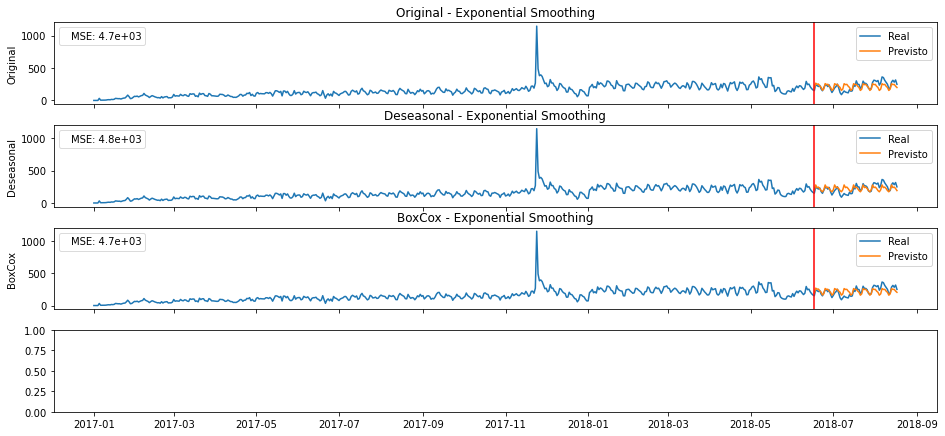

In [73]:
reportES(seriesBoxCox.copy(), 'BoxCox', model_kwargs, fit_kwargs, calcPredTestBoxCox)

## 3.8 Residual - Exponential Smoothing

#### O código abaixo é uma replicação do item 3.5, de forma que só foi alterado a base de entrada de seriesOriginal para seriesResidual, assim verificando as diferenças de resultados ao utilizar diferentes transformações na base. Dessa forma,  não terá comentários nesse item.

In [74]:
alphas = betas = gammas = damping_trend = np.arange(1, step = 0.1)
hyperparam = pd.DataFrame(product(alphas, betas, gammas, damping_trend), columns = ['alpha', 'beta', 'gamma', 'damping_trend'])
hyperparam.head()

alpha  beta  gamma  damping_trend
0    0.0   0.0    0.0            0.0
1    0.0   0.0    0.0            0.1
2    0.0   0.0    0.0            0.2
3    0.0   0.0    0.0            0.3
4    0.0   0.0    0.0            0.4

In [75]:
%%time
if EXECUTE_GRID_SEARCH:
    hyperparam['mse'] = hyperparam.swifter.apply(lambda x: GSES(seriesResidual.copy(), 'Stationary',\
                                                x.alpha, x.beta, x.gamma, x.damping_trend, calcPredTestStationary), axis = 1)

CPU times: total: 0 ns
Wall time: 0 ns


In [76]:
if EXECUTE_GRID_SEARCH:
    display(hyperparam.query('mse == mse.min() and mse != -1'))

In [77]:
params_ = exp_smoothing_configs([FEATURES])

In [78]:
hyperparam_ = pd.DataFrame(params_, columns = ['trend', 'season', 'periods', 'bias', 'method'])

In [79]:
%%time
if EXECUTE_GRID_SEARCH:
    hyperparam_['mse'] = hyperparam_.swifter.apply(lambda x: GSESOPT(seriesResidual.copy(), 'Stationary',\
                                                  x.trend, x.season, x.periods, x.bias, x.method, calcPredTestStationary),\
                                   axis = 1)

CPU times: total: 0 ns
Wall time: 0 ns


In [80]:
if EXECUTE_GRID_SEARCH:
    display(hyperparam_.query('mse == mse.min() and mse != -1'))

In [81]:
model_kwargs = dict(trend = 'add', seasonal = 'add', seasonal_periods = FEATURES, damped_trend = True)
fit_kwargs = dict(smoothing_level = 0.0, smoothing_trend = 0.2, smoothing_seasonal = 0.1, method = 'ls', damping_trend = 0.2)

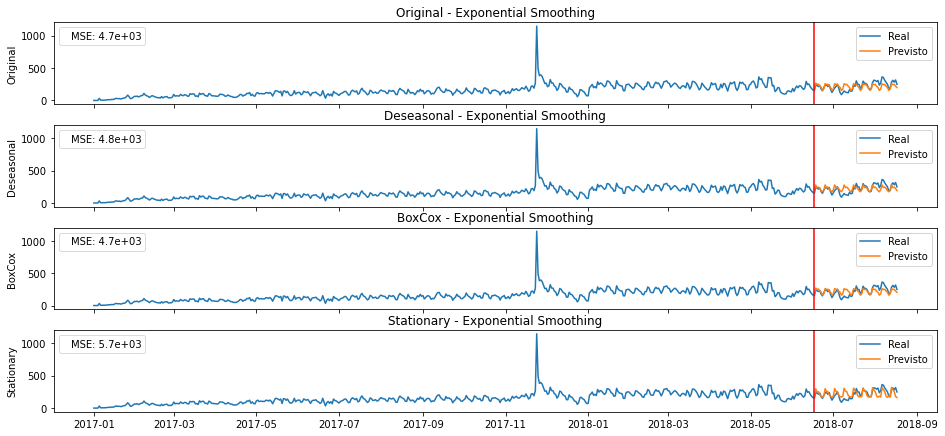

In [82]:
reportES(seriesResidual.copy(), 'Stationary', model_kwargs, fit_kwargs, calcPredTestStationary)

## 3.9 ARIMA

In [83]:
# Report do algoritmo arima, também é adicionado a base de resultados e realizado o plot de acompanhamento
def reportArima(arimaModel, modelName, calcFunction):
    global result
    global figs
    
    mse = []
    rmse = []
    mae = []
    mrv = []
    mpv = []
    
    title = modelName + ' - '  + arimaModel.__str__().strip()
    indexPlot = 0
    
    for train_id, test_id in split_range.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]
        arimaModel.fit(train)
        pred = arimaModel.predict(test.shape[0])
             
        pred, test, indexPlot = calcFunction(train, pred, test)

        mse.append(mean_squared_error(pred, test, squared = True))
        rmse.append(mean_squared_error(pred, test, squared = False))
        mae.append(mean_absolute_error(pred, test))
        mrv.append(np.mean(test))
        mpv.append(np.mean(pred))
    
    result = record(result, title, np.mean(mse), np.mean(rmse), np.mean(mae), np.mean(mrv), np.mean(mpv), False)
    return plot(test.index, pred, mse, title, figs, axs[indexPlot], modelName)

In [84]:
# Reset da figura
figs, axs = plt.subplots(nrows = 4, sharex = True, figsize = (13,6))
figs.align_ylabels()
figs.tight_layout()
plt.close()

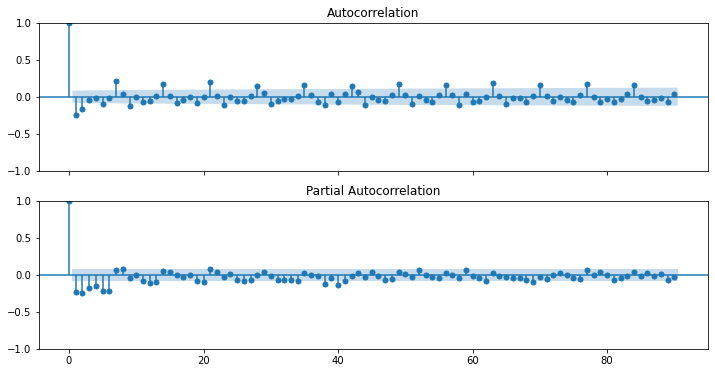

In [85]:
# Correlação entre os periodos com ARIMA

lags = 90

with catch_warnings():
    filterwarnings('ignore')
    fig, ax = plt.subplots(2, figsize = (12, 6), sharex = True)
    plot_acf(seriesOriginal.diff().dropna(), ax = ax[0], lags = lags, missing = 'drop')
    plot_pacf(seriesOriginal.diff().dropna(), ax = ax[1], lags = lags)
    plt.show()

In [86]:
%%time

# Utilizando o auto arima para descobrir os argumentos ideias baseados no conjunto de dado informado
data = seriesOriginal.copy()
arimaModel = auto_arima(seriesOriginal.copy(), m = FEATURES, seasonal = True)
arimaModel

CPU times: total: 22.2 s
Wall time: 22.5 s


ARIMA(order=(1, 1, 2), scoring_args={}, seasonal_order=(0, 0, 2, 7),
      suppress_warnings=True)

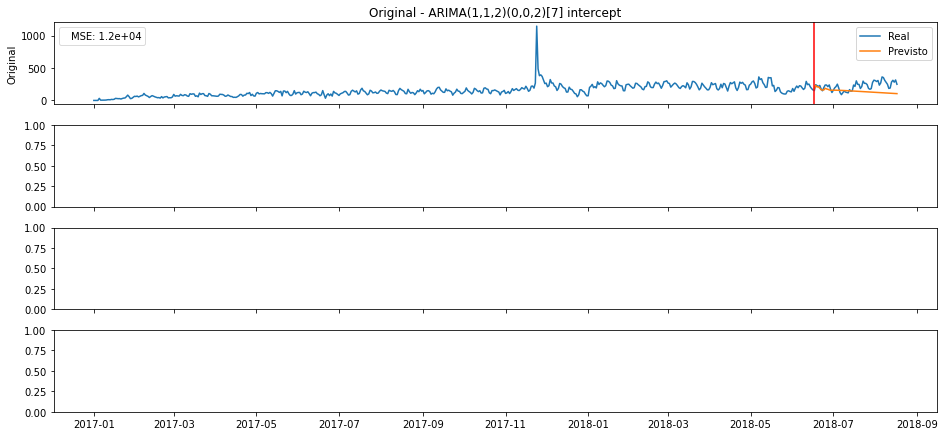

In [87]:
reportArima(arimaModel, 'Original', calcPredTestOriginal)

## 3.10 Deseasonal - ARIMA

#### O código abaixo é uma replicação do item 3.9, de forma que só foi alterado a base de entrada de seriesOriginal para seriesDeseasonal, assim verificando as diferenças de resultados ao utilizar diferentes transformações na base. Dessa forma,  não terá comentários nesse item.

In [88]:
%%time
data = seriesDeseasonal.copy()
arimaModel = auto_arima(data, m = FEATURES, seasonal = False)
arimaModel

C:\Users\herik\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (7) set for non-seasonal fit. Setting to 0



CPU times: total: 2.56 s
Wall time: 2.62 s


ARIMA(order=(2, 1, 1), scoring_args={}, suppress_warnings=True)

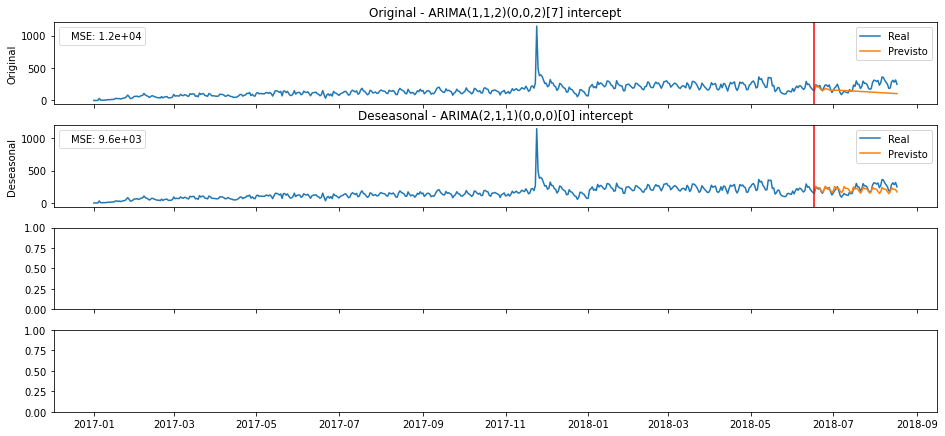

In [89]:
reportArima(arimaModel, 'Deseasonal', calcPredTestseriesDeseasonal)

## 3.11 BoxCox - ARIMA

#### O código abaixo é uma replicação do item 3.9, de forma que só foi alterado a base de entrada de seriesOriginal para boxcox, assim verificando as diferenças de resultados ao utilizar diferentes transformações na base. Dessa forma,  não terá comentários nesse item.

In [90]:
%%time
data = seriesBoxCox.copy()
arimaModel = auto_arima(data, m = FEATURES, seasonal = True)
arimaModel

CPU times: total: 27.3 s
Wall time: 27.3 s


ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(1, 0, 1, 7),
      suppress_warnings=True)

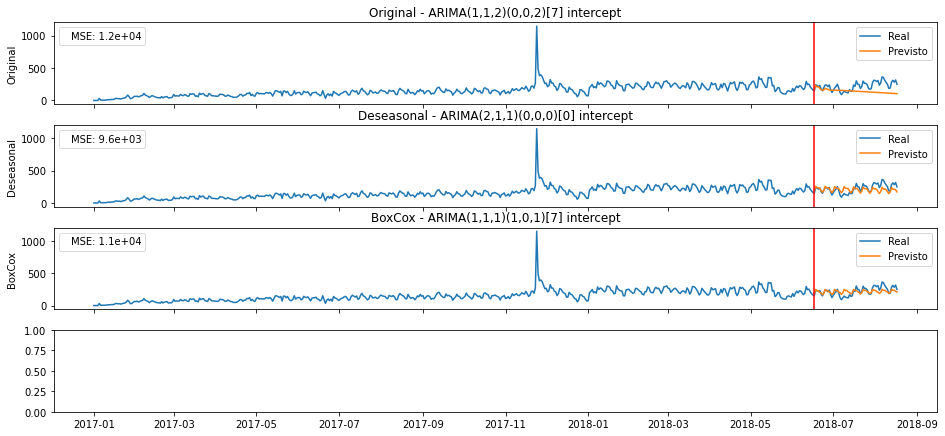

In [91]:
reportArima(arimaModel, 'BoxCox', calcPredTestBoxCox)

## 3.12 Residual - ARIMA

#### O código abaixo é uma replicação do item 3.9, de forma que só foi alterado a base de entrada original para stationary, assim verificando as diferenças de resultados ao utilizar diferentes transformações na base. Dessa forma,  não terá comentários nesse item.

In [92]:
%%time
data = seriesResidual.copy()
arimaModel = auto_arima(data, m = FEATURES, seasonal = False)
arimaModel

C:\Users\herik\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning:

m (7) set for non-seasonal fit. Setting to 0



CPU times: total: 5.98 s
Wall time: 6.1 s


ARIMA(order=(3, 0, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

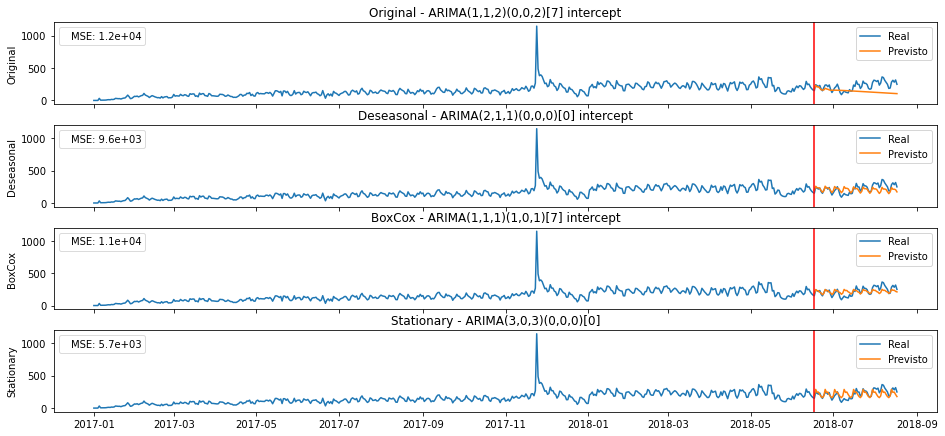

In [93]:
reportArima(arimaModel, 'Stationary', calcPredTestStationary)

In [94]:
result

Algorithm           MSE       RMSE  \
0               Original - Time Series Regression   5296.329792  60.784585   
1             Deseasonal - Time Series Regression    5081.77776  58.208746   
2                 BoxCox - Time Series Regression   5328.602465  61.060147   
3             Stationary - Time Series Regression   6057.828087  64.323443   
4                Original - Exponential Smoothing    4749.16575  55.864659   
5              Deseasonal - Exponential Smoothing   4774.382728    55.5275   
6                  BoxCox - Exponential Smoothing   4653.246578  54.946508   
7              Stationary - Exponential Smoothing   5658.627242   63.86568   
8     Original - ARIMA(1,1,2)(0,0,2)[7] intercept  11599.889603  89.225015   
9   Deseasonal - ARIMA(2,1,1)(0,0,0)[0] intercept   9591.302944  77.051189   
10      BoxCox - ARIMA(1,1,1)(1,0,1)[7] intercept  11393.604917  84.409223   
11            Stationary - ARIMA(3,0,3)(0,0,0)[0]   5675.808118  62.612956   

          MAE Mean_Real_Value Mean_Predict_Value  
0   42.960631      179.560484         168.008596  
1   40.122247      179.560484         164.670085  
2   43.254815      179.560484         165.399796  
3   46.538896      179.560484         184.267746  
4   38.516078      179.560484         165.919136  
5   37.488666      179.560484         166.749778  
6   37.555881      179.560484         166.093056  
7   43.658278      179.560484         179.444886  
8    70.61781      179.560484         194.668305  
9   59.640244      179.560484         191.568473  
10   66.06974      179.560484         206.496282  
11  43.570659      179.560484          169.27759

## 3.13 LSTM

In [95]:
# Redefinindo variaveis globais para o treino utilizando LSTM

BATCH_SIZE = 30

In [96]:
# hypertuning do algoritmo de LSTM
def GSLSTM(data, learning_rate, calcFunction):
    mse = []
    
    # Crossvalidation para cada parte do conjunto
    for train_id, test_id in split_range.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]

        try:
            with catch_warnings():
                filterwarnings('ignore')
                
                # Normalização e reshape do conjunto de treino
                ss = StandardScaler()
                ss.fit(train.values.reshape(-1, 1))
                train_input = ss.transform(train.values.reshape(-1, 1))
                
                # Gerando conjunto de treino com TimeseriesGenerator baseado no conjunto atual e o batch informado
                test_input = train_input[-(FEATURES + 1):]
                test_gen = TimeseriesGenerator(test_input, test_input, length = FEATURES, batch_size = BATCH_SIZE)
                train_gen = TimeseriesGenerator(train_input, train_input, length = FEATURES, batch_size = BATCH_SIZE)
                
                # Reset da sessão
                clear_session()
                
                # Construindo o modelo de LSTM com GlorotUniform pois inicializa de forma normalizada
                initializer = GlorotUniform(seed = SEED)
                model = Sequential()
                
                # 1 camada de LSTM com 64 entradas, 2 camadas densas e uma de normalização intermediando as camadas densas
                model.add(LSTM(64, input_shape = (FEATURES, 1), return_sequences = False))
                model.add(Dense(1, kernel_initializer = initializer))
                model.add(BatchNormalization())
                model.add(Dense(1, kernel_initializer = initializer))
                
                # Configurando o EarlyStopping para o modelo não treinar mais que 3x seguidas se não obtiver melhorias nos resultados
                early_stopping = EarlyStopping(monitor = 'loss', patience = 3, mode = 'min')
                
                # Treinando o modelo com otimizador Adam
                model.compile(loss = 'mse', optimizer = Adam(learning_rate = learning_rate), metrics = ['mae'])
                h = model.fit(train_gen, epochs = EPOCHS, callbacks = [early_stopping], verbose = False)
                pred = np.empty(test.shape[0])
                
                # Realizando predições no conjunto de teste
                for i in range(len(pred)):
                    prediction = model.predict(test_gen, verbose = False)
                    pred[i] = prediction
                    test_input = np.delete(test_input, 0, 0)
                    test_input = np.concatenate((test_input, np.array(prediction).reshape(-1, 1)), axis = 0)
                    test_gen = TimeseriesGenerator(test_input, test_input, length = FEATURES, batch_size = BATCH_SIZE)
                
                # Reorganizando o shape e chamando a função de calculo
                pred = ss.inverse_transform(pred.reshape(-1,1)).reshape(-1)
                pred, test, _ = calcFunction(train, pred, test)      

                mse.append(mean_squared_error(pred, test))
                
        except:
            mse.append(-1)
        
    return np.mean(mse)

In [97]:
# Report do algoritmo LSTM
def reportLSTM(data, modelName, calcFunction, learning_rate):
    global result
    global figs
    
    mse = []
    rmse = []
    mae = []
    mrv = []
    mpv = []
    
    title = modelName + ' - Long Short Term Memory (LSTM)'
    
    # Crossvalidation para cada parte do conjunto
    for train_id, test_id in split_range.split(data):
        train, test = data.iloc[train_id], data.iloc[test_id]
    
        # Normalização e reshape do conjunto de treino
        ss = StandardScaler()
        ss.fit(train.values.reshape(-1, 1))
        train_input = ss.transform(train.values.reshape(-1, 1))

        # Gerando conjunto de treino com TimeseriesGenerator baseado no conjunto atual e o batch informado
        test_input = train_input[-(FEATURES + 1):]
        test_gen = TimeseriesGenerator(test_input, test_input, length = FEATURES, batch_size = BATCH_SIZE)
        train_gen = TimeseriesGenerator(train_input, train_input, length = FEATURES, batch_size = BATCH_SIZE)

        # Reset da sessão
        clear_session()
        
        # Construindo o modelo de LSTM com GlorotUniform pois inicializa de forma normalizada
        initializer = GlorotUniform(seed = SEED)
        model = Sequential()
        
        # 1 camada de LSTM com 64 entradas, 2 camadas densas e uma de normalização intermediando as camadas densas
        model.add(LSTM(64, input_shape = (FEATURES, 1), return_sequences = False))
        model.add(Dense(1, kernel_initializer = initializer))
        model.add(BatchNormalization())
        model.add(Dense(1, kernel_initializer = initializer))
        
        # Configurando o EarlyStopping para o modelo não treinar mais que 3x seguidas se não obtiver melhorias nos resultados
        early_stopping = EarlyStopping(monitor = 'loss', patience = 3, mode = 'min')
        
        # Treinando o modelo com otimizador Adam
        model.compile(loss = 'mse', optimizer = Adam(learning_rate = learning_rate), metrics = ['mae'])
        h = model.fit(train_gen, epochs = EPOCHS, callbacks = [early_stopping], verbose = False)
        pred = np.empty(test.shape[0])

        # Realizando predições no conjunto de teste
        for i in range(len(pred)):
            prediction = model.predict(test_gen, verbose = False)
            pred[i] = prediction
            test_input = np.delete(test_input, 0, 0)
            test_input = np.concatenate((test_input, np.array(prediction).reshape(-1, 1)), axis = 0)
            test_gen = TimeseriesGenerator(test_input, test_input, length = FEATURES, batch_size = BATCH_SIZE)

        # Reorganizando o shape e chamando a função de calculo
        pred = ss.inverse_transform(pred.reshape(-1,1)).reshape(-1)
        pred, test, indexPlot = calcFunction(train, pred, test)

        mse.append(mean_squared_error(pred, test, squared = True))
        rmse.append(mean_squared_error(pred, test, squared = False))
        mae.append(mean_absolute_error(pred, test))
        mrv.append(np.mean(test))
        mpv.append(np.mean(pred))
    
    result = record(result, title, np.mean(mse), np.mean(rmse), np.mean(mae), np.mean(mrv), np.mean(mpv), False)
    return plot(test.index, pred, mse, title, figs, axs[indexPlot], modelName)

In [98]:
# Gerando tabela de hypertunning com taxas de learning_rate
learning_rates = np.logspace(-5, 1, 7)
hyperparam = pd.DataFrame(learning_rates, columns = ['learning_rate'])
hyperparam.head()

learning_rate
0        0.00001
1        0.00010
2        0.00100
3        0.01000
4        0.10000

In [99]:
%%time
if EXECUTE_GRID_SEARCH:
    hyperparam['mse'] = hyperparam.swifter.apply(lambda x: GSLSTM(seriesOriginal.copy(), x.learning_rate, calcPredTestOriginal), axis = 1)

CPU times: total: 0 ns
Wall time: 0 ns


In [100]:
if EXECUTE_GRID_SEARCH:
    display(hyperparam.query('mse == mse.min() and mse != -1'))

In [101]:
# Reset da figura
figs, axs = plt.subplots(nrows = 4, sharex = True, figsize = (13,6))
figs.align_ylabels()
figs.tight_layout()
plt.close()

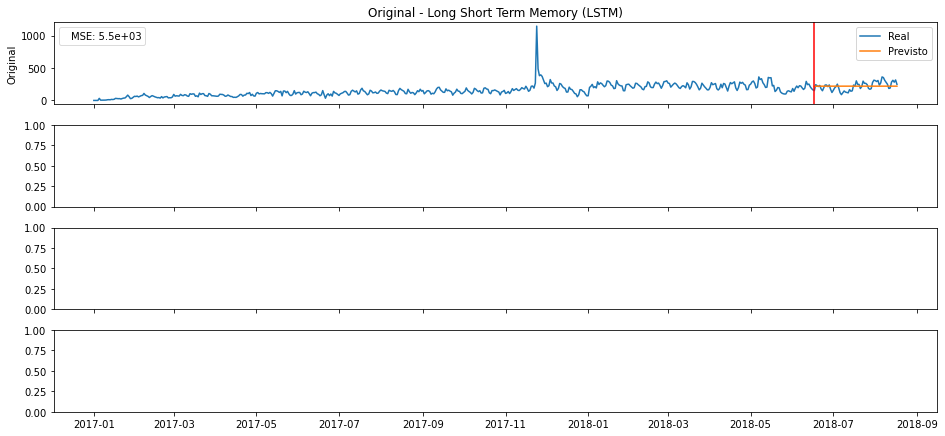

In [102]:
reportLSTM(seriesOriginal.copy(), 'Original', calcPredTestOriginal, 0.0001)

## 3.14 Deseasonal - LSTM

#### O código abaixo é uma replicação do item 3.13, de forma que só foi alterado a base de entrada original para seriesDeseasonal, assim verificando as diferenças de resultados ao utilizar diferentes transformações na base. Dessa forma,  não terá comentários nesse item.

In [103]:
learning_rates = np.logspace(-5, 1, 7)
hyperparam = pd.DataFrame(learning_rates, columns = ['learning_rate'])
hyperparam.head()

learning_rate
0        0.00001
1        0.00010
2        0.00100
3        0.01000
4        0.10000

In [104]:
%%time

if EXECUTE_GRID_SEARCH:
    hyperparam['mse'] = hyperparam.swifter.apply(lambda x: GSLSTM(seriesDeseasonal.copy(), x.learning_rate, calcPredTestseriesDeseasonal), axis = 1)

CPU times: total: 0 ns
Wall time: 1e+03 µs


In [105]:
if EXECUTE_GRID_SEARCH:
    display(hyperparam.query('mse == mse.min() and mse != -1'))

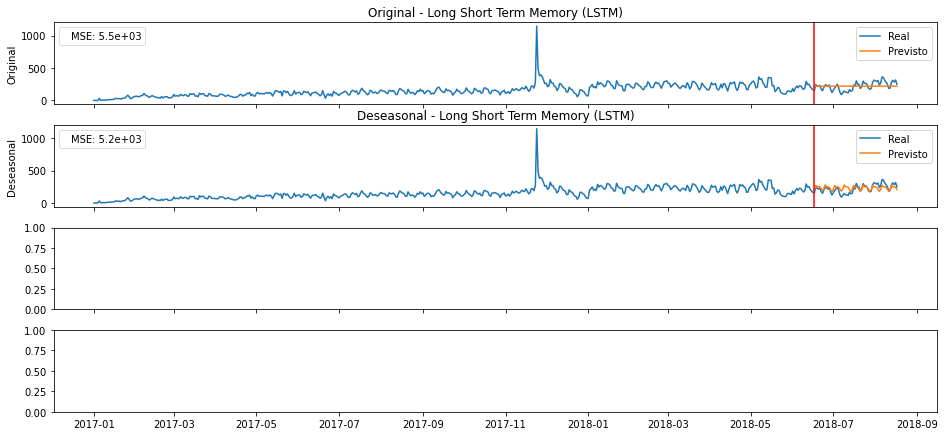

In [106]:
reportLSTM(seriesDeseasonal.copy(), 'Deseasonal', calcPredTestseriesDeseasonal, 0.01)

## 3.15 BoxCox - LSTM

#### O código abaixo é uma replicação do item 3.13, de forma que só foi alterado a base de entrada original para boxcox, assim verificando as diferenças de resultados ao utilizar diferentes transformações na base. Dessa forma,  não terá comentários nesse item.

In [107]:
learning_rates = np.logspace(-5, 1, 7)
hyperparam = pd.DataFrame(learning_rates, columns = ['learning_rate'])
hyperparam.head()

learning_rate
0        0.00001
1        0.00010
2        0.00100
3        0.01000
4        0.10000

In [108]:
%%time

if EXECUTE_GRID_SEARCH:
    hyperparam['mse'] = hyperparam.swifter.apply(lambda x: GSLSTM(seriesBoxCox.copy(), x.learning_rate, calcPredTestBoxCox), axis = 1)

CPU times: total: 0 ns
Wall time: 1e+03 µs


In [109]:
if EXECUTE_GRID_SEARCH:
    display(hyperparam.query('mse == mse.min() and mse != -1'))

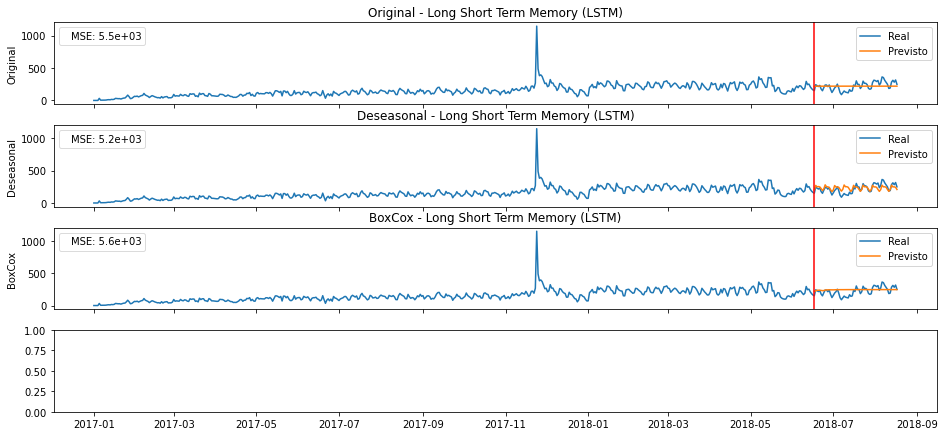

In [110]:
reportLSTM(seriesBoxCox.copy(), 'BoxCox', calcPredTestBoxCox, 0.001)

## 3.16 Residual - LSTM

#### O código abaixo é uma replicação do item 3.13, de forma que só foi alterado a base de entrada original para stationary, assim verificando as diferenças de resultados ao utilizar diferentes transformações na base. Dessa forma,  não terá comentários nesse item.

In [111]:
learning_rates = np.logspace(-5, 1, 7)
hyperparam = pd.DataFrame(learning_rates, columns = ['learning_rate'])
hyperparam.head()

learning_rate
0        0.00001
1        0.00010
2        0.00100
3        0.01000
4        0.10000

In [112]:
%%time

if EXECUTE_GRID_SEARCH:
    hyperparam['mse'] = hyperparam.swifter.apply(lambda x: GSLSTM(seriesResidual.copy(), x.learning_rate, calcPredTestStationary), axis = 1)

CPU times: total: 0 ns
Wall time: 999 µs


In [113]:
if EXECUTE_GRID_SEARCH:
    display(hyperparam.query('mse == mse.min() and mse != -1'))

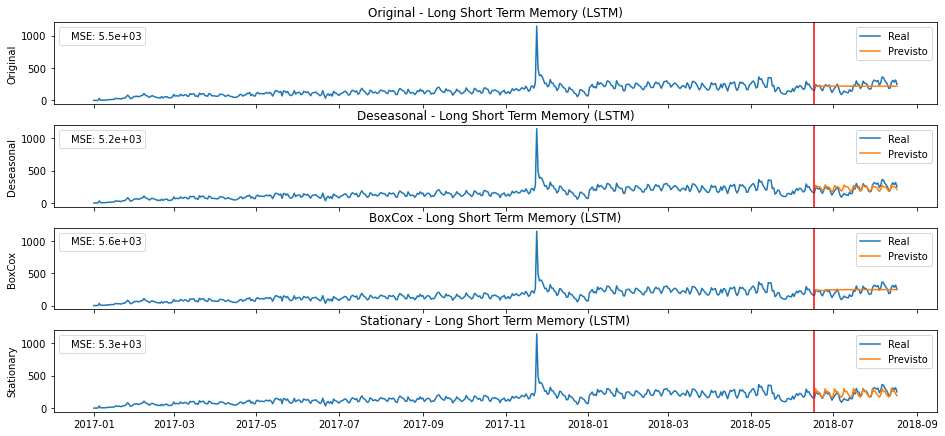

In [114]:
reportLSTM(seriesResidual.copy(), 'Stationary', calcPredTestStationary, 0.00001)

In [115]:
result

Algorithm           MSE       RMSE  \
0               Original - Time Series Regression   5296.329792  60.784585   
1             Deseasonal - Time Series Regression    5081.77776  58.208746   
2                 BoxCox - Time Series Regression   5328.602465  61.060147   
3             Stationary - Time Series Regression   6057.828087  64.323443   
4                Original - Exponential Smoothing    4749.16575  55.864659   
5              Deseasonal - Exponential Smoothing   4774.382728    55.5275   
6                  BoxCox - Exponential Smoothing   4653.246578  54.946508   
7              Stationary - Exponential Smoothing   5658.627242   63.86568   
8     Original - ARIMA(1,1,2)(0,0,2)[7] intercept  11599.889603  89.225015   
9   Deseasonal - ARIMA(2,1,1)(0,0,0)[0] intercept   9591.302944  77.051189   
10      BoxCox - ARIMA(1,1,1)(1,0,1)[7] intercept  11393.604917  84.409223   
11            Stationary - ARIMA(3,0,3)(0,0,0)[0]   5675.808118  62.612956   
12       Original - Long Short Term Memory (LSTM)   5540.899288  63.767823   
13     Deseasonal - Long Short Term Memory (LSTM)    5226.05025  59.237294   
14         BoxCox - Long Short Term Memory (LSTM)   5625.496805  64.244318   
15     Stationary - Long Short Term Memory (LSTM)   5331.739095  59.758025   

          MAE Mean_Real_Value Mean_Predict_Value  
0   42.960631      179.560484         168.008596  
1   40.122247      179.560484         164.670085  
2   43.254815      179.560484         165.399796  
3   46.538896      179.560484         184.267746  
4   38.516078      179.560484         165.919136  
5   37.488666      179.560484         166.749778  
6   37.555881      179.560484         166.093056  
7   43.658278      179.560484         179.444886  
8    70.61781      179.560484         194.668305  
9   59.640244      179.560484         191.568473  
10   66.06974      179.560484         206.496282  
11  43.570659      179.560484          169.27759  
12   45.77829      179.560484         161.267352  
13  41.330007      179.560484         166.254071  
14  45.981937      179.560484         160.970071  
15  41.651379      179.560484         181.298586

## 4. Comparação

In [116]:
# Tratando nomes e criando colunas de controle para os resultados gerados
topResult = (
    result 
    .assign(Full_Name = lambda x: x.Algorithm.apply(lambda a: a.split('(')[0]
                                                   .replace('ARIMA', 'Auto Arima')
                                                   .replace('Long Short Term Memory', 'LSTM')))
    .assign(Data_Category = lambda x: x.Algorithm.apply(lambda a: a.split(' - ')[0]))
    .assign(Algorithm = lambda x: x.Algorithm.apply(lambda a: a.split(' - ')[1].split('(')[0]
                                                   .replace('ARIMA', 'Auto Arima')
                                                   .replace('Long Short Term Memory', 'LSTM')))
    .sort_values('MSE')
)

In [117]:
topResult.head()

Algorithm          MSE       RMSE        MAE Mean_Real_Value  \
6    Exponential Smoothing  4653.246578  54.946508  37.555881      179.560484   
4    Exponential Smoothing   4749.16575  55.864659  38.516078      179.560484   
5    Exponential Smoothing  4774.382728    55.5275  37.488666      179.560484   
1   Time Series Regression   5081.77776  58.208746  40.122247      179.560484   
13                   LSTM    5226.05025  59.237294  41.330007      179.560484   

   Mean_Predict_Value                            Full_Name Data_Category  
6          166.093056       BoxCox - Exponential Smoothing        BoxCox  
4          165.919136     Original - Exponential Smoothing      Original  
5          166.749778   Deseasonal - Exponential Smoothing    Deseasonal  
1          164.670085  Deseasonal - Time Series Regression    Deseasonal  
13         166.254071                   Deseasonal - LSTM     Deseasonal

In [118]:
# Plot dos resultados obtidos por ordem ascendente do MSE

colors = {'Time Series Regression':'red',
          'Exponential Smoothing':'orange',
          'Auto Arima': 'green',
          'LSTM ': 'blue'}

# plotly figure
fig = go.Figure(layout = go.Layout(yaxis = {'type': 'category', 'title': 'Algoritmo e Categoria'},
                        xaxis = {'title': 'MSE'},
                        title = 'MSE por Algoritmo e Tipo de Dado'))

for t in topResult['Algorithm'].unique():
    topResultFiltered = topResult[topResult['Algorithm']== t].copy()
    fig.add_traces(go.Bar(x = topResultFiltered['MSE'], y = topResultFiltered['Full_Name'], name = str(t),\
                          marker_color = str(colors[t]), orientation = 'h',
                          text = round(topResultFiltered['MSE'].astype(np.double)), textposition = 'outside'))
    
    
fig.update_layout(yaxis = {'categoryorder':'total descending'}, autosize = False,
                  width = 1450,
                  height = 800)    
    
fig.show()

## 4. Previsões Futuras

In [239]:
pred_range = pd.date_range(datetime.date(2018, 6, 17), datetime.date(2018, 10, 31))
split_range = TimeSeriesSplit(n_splits = 2, max_train_size = pred_range.shape[0], test_size = pred_range.shape[0])

### 4.1 BoxCox - Exponential Smoothing

In [281]:
# Alocando melhor modelo a memória e separando base de treino
data = seriesBoxCox.copy()
train = data[datetime.date(2017, 1, 1): datetime.date(2018, 6, 16)]

In [282]:
# Treinando modelo baseado dos parâmetros descobertos na fase de modelagem
ES = (
    ExponentialSmoothing(train, trend = 'add', seasonal = 'add', seasonal_periods = FEATURES, damped_trend = True)
    .fit(smoothing_level = 0.1, smoothing_trend = 0.7, smoothing_seasonal = 0.0, method = 'ls', damping_trend = 0.8)
)

In [283]:
# Calculando a previsão até o final do ano de 2018
pred = ES.predict(str(data.index[0]), '2018-12-31')
pred, data, _ = calcPredTestBoxCox(train, pred, data)  

In [284]:
# Plot

# Definição dos dados no plot
plot_data = [go.Scatter(x = seriesOriginal.index,
                        y = seriesOriginal,
                        name = 'Real'),
             go.Scatter(x = pred.index,
                        y = pred,
                        name = 'Previsto')]

# Layout
plot_layout = go.Layout(xaxis = {'title': 'Período'},
                        yaxis = {'title': 'Vendas'}, 
                        title = 'BoxCox - Exponential Smoothing')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)

fig.add_vrect(x0 = '2018-06-17', x1 = '2018-08-17', 
              annotation_text = 'Previsão base<br>de teste', annotation_position = 'top left',
              annotation = dict(font_size = 23, font_family = 'Times New Roman'),
              fillcolor = 'red', opacity = 0.2, line_width = 0)

fig.add_vrect(x0 = '2018-08-17', x1 = '2018-12-31', 
              annotation_text = 'Projeção de<br>Vendas Futuras', annotation_position = 'top left',
              annotation = dict(font_size = 23, font_family = 'Times New Roman'),
              fillcolor = 'green', opacity = 0.2, line_width = 0)

pyoff.iplot(fig)

In [193]:
ES.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:                     None   No. Observations:                  532
Model:             ExponentialSmoothing   SSE                           7800.497
Optimized:                         True   AIC                           1452.579
Trend:                         Additive   BIC                           1503.899
Seasonal:                      Additive   AICC                          1453.392
Seasonal Periods:                     7   Date:                 Wed, 05 Oct 2022
Box-Cox:                          False   Time:                         19:04:26
Box-Cox Coeff.:                    None                                         
=================================================================================
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha                False
smoothing_trend               0.7000000                 beta                False
smoothing_seasonal             0.000000                gamma                False
initial_level                -5.0438933                  l.0                 True
initial_trend                 1.3021823                  b.0                 True
damping_trend                 0.8000000                  phi                False
initial_seasons.0             0.5899851                  s.0                 True
initial_seasons.1             4.8396236                  s.1                 True
initial_seasons.2             4.7464382                  s.2                 True
initial_seasons.3             4.2431176                  s.3                 True
initial_seasons.4             3.6034685                  s.4                 True
initial_seasons.5             2.5651724                  s.5                 True
initial_seasons.6            -0.7669847                  s.6                 True
---------------------------------------------------------------------------------
"""

In [194]:
# Alocando melhor modelo a memória e separando base de treino
data = seriesBoxCox.copy()
train = data[datetime.date(2017, 1, 1): datetime.date(2018, 6, 16)]

# Treinando modelo baseado dos parâmetros descobertos na fase de modelagem
ES = (
    ExponentialSmoothing(train, trend = 'add', seasonal = 'add', seasonal_periods = FEATURES, damped_trend = True)
    .fit(smoothing_level = 0.1, smoothing_trend = 0.7, smoothing_seasonal = 0.0, method = 'ls', damping_trend = 0.8)
)

# Calculando a previsão até o final do ano de 2018
pred = ES.predict(str(data.index[0]), '2018-08-17')

In [195]:
# Plot

# Definição dos dados no plot
plot_data = [go.Scatter(x = data.index,
                        y = data,
                        name = 'Real'),
             go.Scatter(x = pred.index,
                        y = pred,
                        name = 'Previsto', fill = "tonexty")]

# Layout
plot_layout = go.Layout(xaxis = {'title': 'Período'},
                        yaxis = {'title': 'Vendas'}, 
                        title = 'Deseasonal - Exponential Smoothing')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)

pyoff.iplot(fig)

### 4.2 Original - LSTM

In [573]:
# Converte array para matrix utilizando x = t e y = t + look_back
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [584]:
seriesOriginal[532:]

2018-06-17    151
2018-06-18    243
2018-06-19    228
2018-06-20    215
2018-06-21    232
             ... 
2018-08-13    284
2018-08-14    311
2018-08-15    282
2018-08-16    316
2018-08-17    249
Freq: D, Name: order_purchase_timestamp, Length: 62, dtype: int64

In [574]:
# Separando dados e index da série
dataInfo = pd.DataFrame(seriesOriginal.copy()).values.astype('float32')
dataTime = seriesOriginal.copy().index

In [575]:
# Aplicando normalização
scaler = MinMaxScaler(feature_range =(0, 1))
dataset = scaler.fit_transform(dataInfo)

In [576]:
# Separando base de treino e teste
train_size = 532
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [577]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [578]:
# Reshape para: [dataset, steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [579]:
# Construindo o modelo de LSTM com GlorotUniform pois inicializa de forma normalizada
initializer = GlorotUniform(seed = SEED)
model = Sequential()

# 1 camada de LSTM com 4 entradas e 2 camadas densas
model.add(LSTM(12, input_shape = (1, look_back)))
model.add(Dense(1, kernel_initializer = initializer))
model.add(Dense(1, kernel_initializer = initializer))

# Configurando o EarlyStopping para o modelo não treinar mais que 3x seguidas se não obtiver melhorias nos resultados
early_stopping = EarlyStopping(monitor = 'loss', patience = 3, mode = 'min')

# Treinando o modelo com otimizador Adam
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
model.fit(trainX, trainY, epochs = EPOCHS, batch_size = 1, callbacks = [early_stopping], verbose = True)

Epoch 1/100
530/530 [==============================] - 2s 1ms/step - loss: 0.0067 - mae: 0.0590
Epoch 2/100
530/530 [==============================] - 1s 1ms/step - loss: 0.0046 - mae: 0.0478
Epoch 3/100
530/530 [==============================] - 1s 1ms/step - loss: 0.0031 - mae: 0.0355
Epoch 4/100
530/530 [==============================] - 1s 1ms/step - loss: 0.0027 - mae: 0.0293
Epoch 5/100
530/530 [==============================] - 1s 1ms/step - loss: 0.0025 - mae: 0.0266
Epoch 6/100
530/530 [==============================] - 1s 1ms/step - loss: 0.0025 - mae: 0.0261
Epoch 7/100
530/530 [==============================] - 1s 1ms/step - loss: 0.0024 - mae: 0.0257
Epoch 8/100
530/530 [==============================] - 1s 1ms/step - loss: 0.0024 - mae: 0.0260
Epoch 9/100
530/530 [==============================] - 1s 1ms/step - loss: 0.0024 - mae: 0.0258
Epoch 10/100
530/530 [==============================] - 1s 1ms/step - loss: 0.0024 - mae: 0.0256
Epoch 11/100
530/530 [=================

In [580]:
# Calcula predições
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Reverte normalização
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calcula MSE
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0], squared = True))
print('Dataset de treino: %.2f MSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0], squared = True))
print('Dataset de teste: %.2f MSE' % (testScore))

# Calcula RMSE
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0], squared = False))
print('Dataset de treino: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0], squared = False))
print('Dataset de teste: %.2f RMSE' % (testScore))

2/2 [==============================] - 0s 2ms/step
Dataset de treino: 52.72 MSE
Dataset de teste: 45.64 MSE
Dataset de treino: 7.26 RMSE
Dataset de teste: 6.76 RMSE


In [654]:
pred_range = np.empty(135)
predictArr = testX

In [656]:
for i in range(pred_range):
    prediction = model.predict(predictArr, verbose = False)
    predictArr = np.concatenate((predictArr, np.reshape(prediction[-1][0], (1 , 1 , 1))))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134


In [667]:
testPredict = scaler.inverse_transform(np.reshape(predictArr, (predictArr.shape[0] , predictArr.shape[1])))

In [671]:
# Plot

# Definição dos dados no plot
plot_data = [go.Scatter(x = dataTime,
                        y = scaler.inverse_transform(dataset).reshape(-1),
                        name = 'Real'),
             go.Scatter(x = pd.date_range(datetime.date(2017, 1, 1), datetime.date(2018, 12, 31)),
                        y = np.concatenate((trainPredict, testPredict)).reshape(-1),
                        name = 'Previsto')]

# Layout
plot_layout = go.Layout(xaxis = {'title': 'Período'},
                        yaxis = {'title': 'Vendas'}, 
                        title = 'Original - LSTM')

# Plot da figura
fig = go.Figure(data = plot_data, layout = plot_layout)

fig.add_vrect(x0 = '2018-06-17', x1 = '2018-08-17', 
              annotation_text = 'Previsão base<br>de teste', annotation_position = 'top left',
              annotation = dict(font_size = 23, font_family = 'Times New Roman'),
              fillcolor = 'red', opacity = 0.2, line_width = 0)

fig.add_vrect(x0 = '2018-08-17', x1 = '2018-12-31', 
              annotation_text = 'Projeção de<br>Vendas Futuras', annotation_position = 'top left',
              annotation = dict(font_size = 23, font_family = 'Times New Roman'),
              fillcolor = 'green', opacity = 0.2, line_width = 0)

pyoff.iplot(fig)